In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import shap 
import xgboost as xgb


# Scikit-lean imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings

# I am adding this line to ignore all the futurewarnings that show up when i run the code.
# Which can clutter the final output
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style('whitegrid')

# Load the data with robust error handling
try:
    file_path = "../data/Pred_Ast_Diam_2.csv"
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully.")
    print(f"Shape: {df.shape}\n")
    print("First 5 rows:")
    # Use display() for better formatting in some environments, or just df.head()
    display(df.head())
except FileNotFoundError:
    print(f"Error: Could not find the file at '{file_path}'. Please check the path.")
    df = pd.DataFrame() # Create empty dataframe to prevent further errors


Dataset Loaded Successfully.
Shape: (126497, 23)

First 5 rows:


,orbit_id,e,a,i,om,w,ma,n,tp,moid,...,data_arc,n_obs_used,rms,diameter,albedo,diameter_sigma,first_year_obs,first_month_obs,last_obs_year,last_obs_month
0,JPL 35,0.242027,2.201791,2.536221,313.311389,18.989048,301.072249,0.301675,2.458796e+06,0.657747,...,46399.0,2611,0.46222,9.300,0.2082,0.800,1892,10,2019,10
1,JPL 25,0.256856,2.338209,22.326589,10.489602,105.115594,87.454449,0.275663,2.458283e+06,0.875501,...,38117.0,1528,0.38116,9.822,0.3140,0.130,1915,4,2019,8
2,JPL 28,0.160543,2.228812,1.747387,121.579382,252.465454,208.942016,0.296206,2.459110e+06,0.871683,...,36040.0,2357,0.44671,8.196,0.3790,0.100,1920,9,2019,5
3,JPL 35,0.167945,2.241299,2.428619,161.636895,172.846491,20.350289,0.293734,2.458531e+06,0.854020,...,33289.0,2574,0.43691,6.534,0.2170,0.068,1928,10,2019,11
4,JPL 34,0.253295,2.467536,6.757106,137.130656,259.158793,127.366908,0.254278,2.458100e+06,0.862972,...,39907.0,2523,0.44695,9.111,0.2560,0.303,1910,2,2019,5


Initial Statistical Summary

With the data loaded, a statistical summary proviides immediatte insights into the scale and distribution of the nnumeric features. The .describe() method is an efficient way to get this overview.

In [6]:
if not df.empty:
    #check data typees and for missing values
    print("Data Information: ")
    df.info()
    #Generate descriptive statistics for numeric coloumns
    print("/nStatistical Summary:")
    display(df.describe())

Data Information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126497 entries, 0 to 126496
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   orbit_id         126497 non-null  object 
 1   e                126497 non-null  float64
 2   a                126497 non-null  float64
 3   i                126497 non-null  float64
 4   om               126497 non-null  float64
 5   w                126497 non-null  float64
 6   ma               126497 non-null  float64
 7   n                126497 non-null  float64
 8   tp               126497 non-null  float64
 9   moid             126497 non-null  float64
 10  moid_jup         126497 non-null  float64
 11  class            126497 non-null  object 
 12  producer         126497 non-null  object 
 13  data_arc         126497 non-null  float64
 14  n_obs_used       126497 non-null  int64  
 15  rms              126497 non-null  float64
 16  diameter         12

,e,a,i,om,w,ma,n,tp,moid,moid_jup,data_arc,n_obs_used,rms,diameter,albedo,diameter_sigma,first_year_obs,first_month_obs,last_obs_year,last_obs_month
count,126497.000000,126497.000000,126497.000000,126497.000000,126497.000000,126497.000000,126497.000000,1.264970e+05,126497.000000,126497.000000,126497.000000,126497.000000,126497.000000,126497.000000,126497.000000,126497.000000,126497.000000,126497.000000,126497.000000,126497.000000
mean,0.146644,2.756965,10.203665,169.819406,181.823887,182.532163,0.223042,2.458473e+06,1.372152,2.103674,8327.433417,619.322261,0.556354,4.162426,0.133238,0.459791,1995.518985,6.819292,2018.317351,6.839364
std,0.076841,0.453027,6.689924,102.749965,103.538522,103.416049,0.054299,8.544471e+02,0.381999,0.401889,4652.967177,518.067224,0.091134,1.933024,0.112034,0.404647,11.947776,3.534653,2.010448,3.590190
min,0.000488,0.626226,0.021855,0.000929,0.004466,0.000517,0.001698,2.451624e+06,0.000166,0.005081,1.000000,5.000000,0.054414,0.008000,0.001000,0.001000,1892.000000,1.000000,2000.000000,1.000000
25%,0.091182,2.510297,5.051481,82.100534,91.822257,93.746347,0.182872,2.458154e+06,1.068410,1.837530,6295.000000,217.000000,0.520510,2.701000,0.053000,0.183000,1993.000000,3.000000,2019.000000,4.000000
50%,0.140047,2.729370,9.244113,160.539684,183.660501,185.542573,0.218580,2.458589e+06,1.353690,2.112610,7527.000000,471.000000,0.554530,3.787000,0.080000,0.337000,1998.000000,8.000000,2019.000000,6.000000
75%,0.192297,3.074005,13.538838,256.258893,271.540490,270.957509,0.247809,2.459022e+06,1.672490,2.385130,9425.000000,901.000000,0.589510,5.265000,0.196000,0.617000,2001.000000,10.000000,2019.000000,11.000000
max,0.968381,69.576833,158.535394,359.990858,359.995174,359.999226,1.988877,2.461586e+06,4.035760,4.419670,46399.000000,4611.000000,8.632100,10.240000,1.000000,22.277000,2014.000000,12.000000,2019.000000,12.000000


Initial Findings:
- The dataset contains 126,497 entries and 23 coloumns.
- The diameter column shows a mean of 4.16 km and a median (50%) of 3.79 km. The mean being larger than the median indicates a right-skew in the distribution, which is confirmed by the visualization below. This skewness is a key characteristic to address for optimizing model performance.


Visualizing Key Distributions
To confirm the skewness observed in the statistics, we will visualize the distribution of the target variable, diameter.

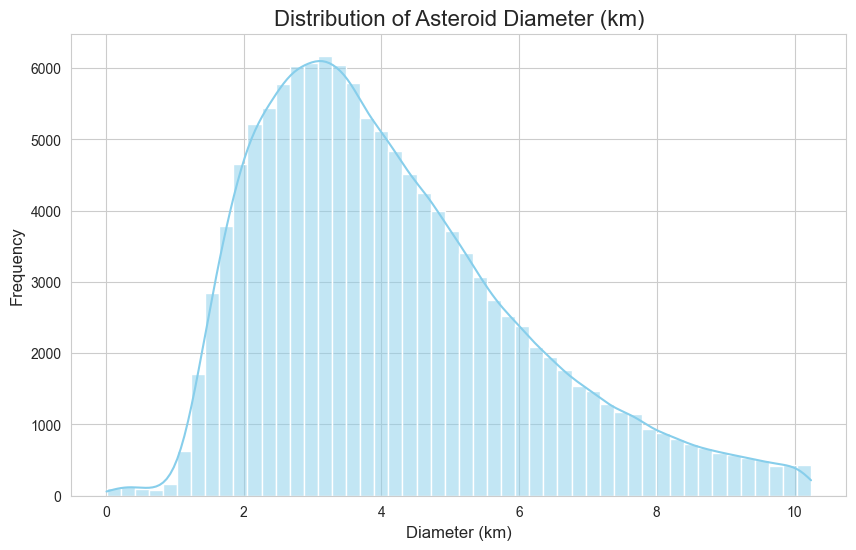

In [5]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['diameter'], kde=True, bins=50, color='skyblue')
    plt.title('Distribution of Asteroid Diameter (km)', fontsize=16)
    plt.xlabel('Diameter (km)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

The histogram clearly visualizes the heavy right-skew, with a large concentration of asteroids at smaller diameters and a long tail extending towards larger sizes. This insight validates our strategy to apply a logarithmic transformation to the target variable in the preprocessing stage.

Stage 2: Exploratory Data Analysis (EDA)
In this stage, we explore the relationships between different features, particularly their correlation with the target variable, diameter.

Correlation Heatmap
A heatmap provides a comprehensive overview of the linear correlations between all numeric variables.

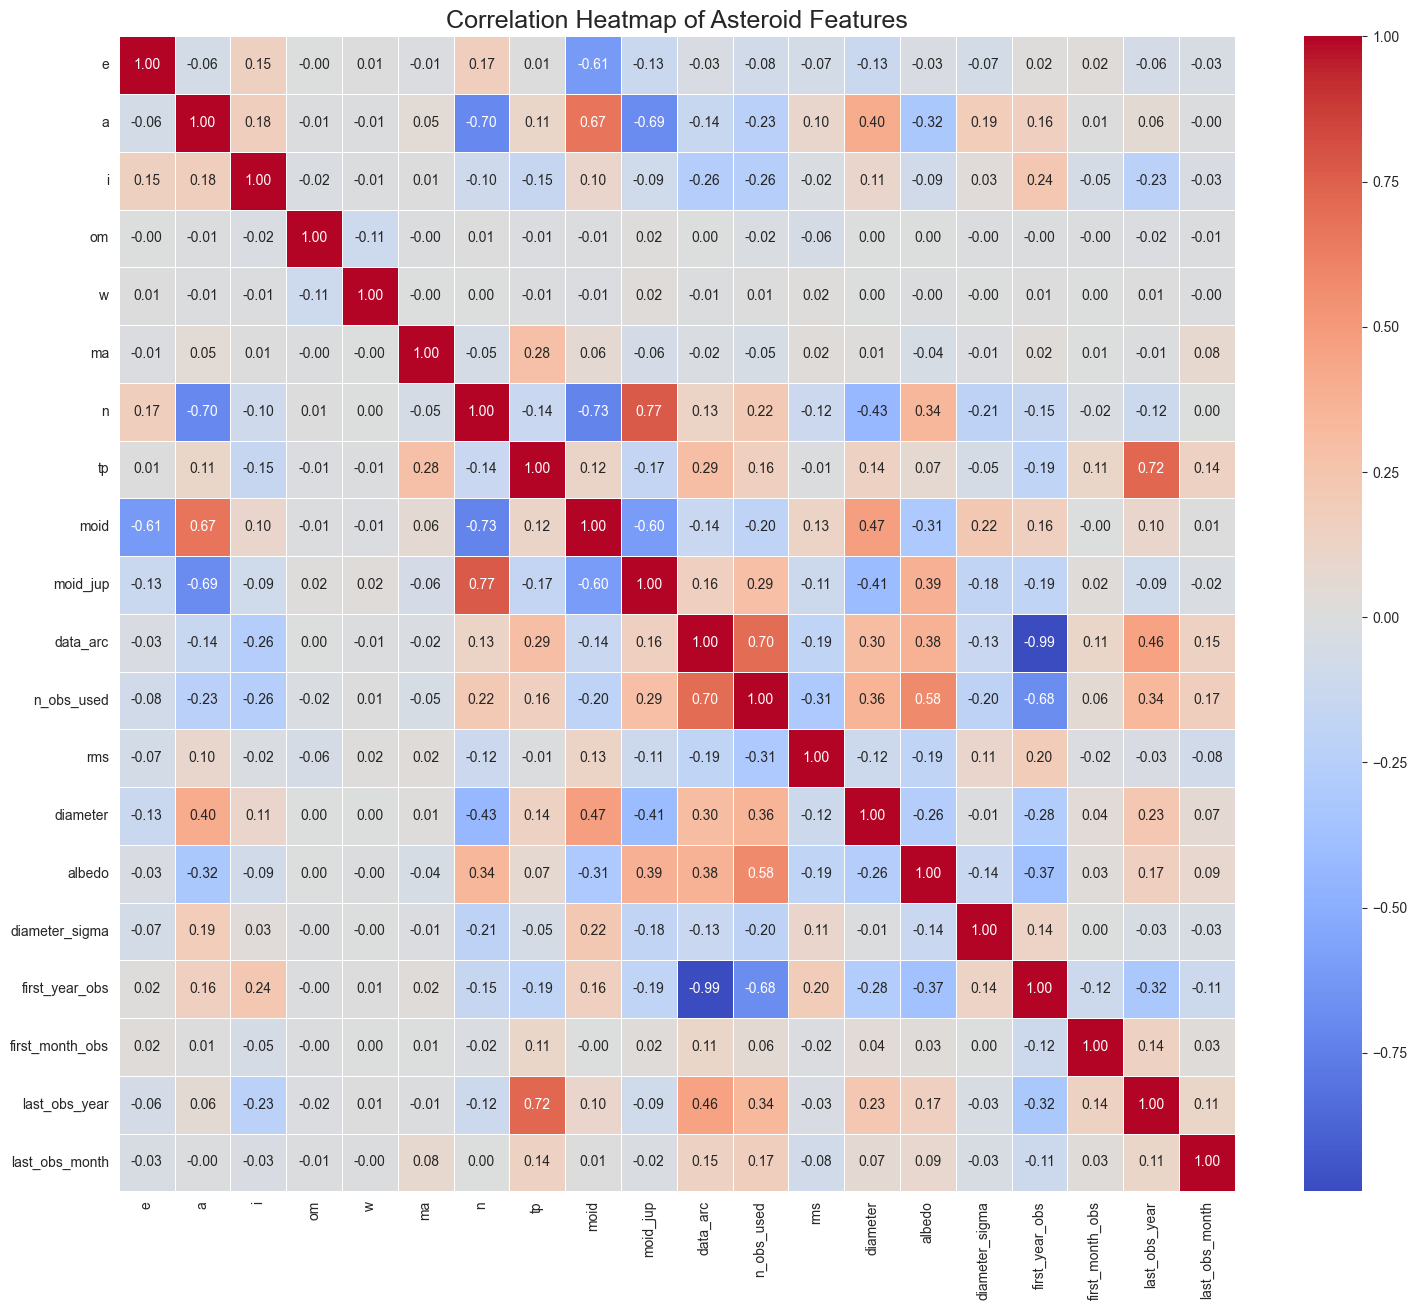

In [7]:
if not df.empty:
    plt.figure(figsize=(18, 15))
    correlation_matrix = df.corr(numeric_only=True)
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Heatmap of Asteroid Features', fontsize=18)
    plt.show()

Heatmap Insights:

- The target variable diameter has the strongest positive correlations with moid (Minimum Orbit Intersection Distance) at 0.47 and a (semi-major axis) at 0.40.

- It has a notable negative correlation with albedo at -0.26, which is physically intuitive: asteroids with higher reflectivity (brighter) tend to be smaller for a given absolute magnitude.

Advanced Bivariate Analysis
To avoid the issue of overplotting seen in standard scatter plots with large datasets, a jointplot with a hexagonal binning (kind='hex') is used. This visualizes the density of points, providing a much clearer view of the relationship.

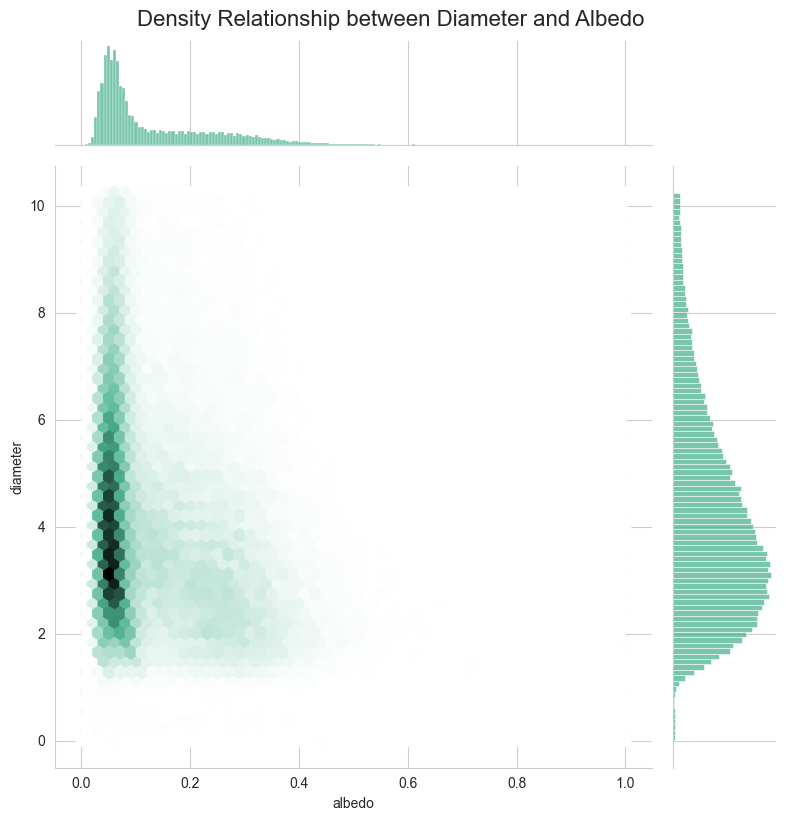

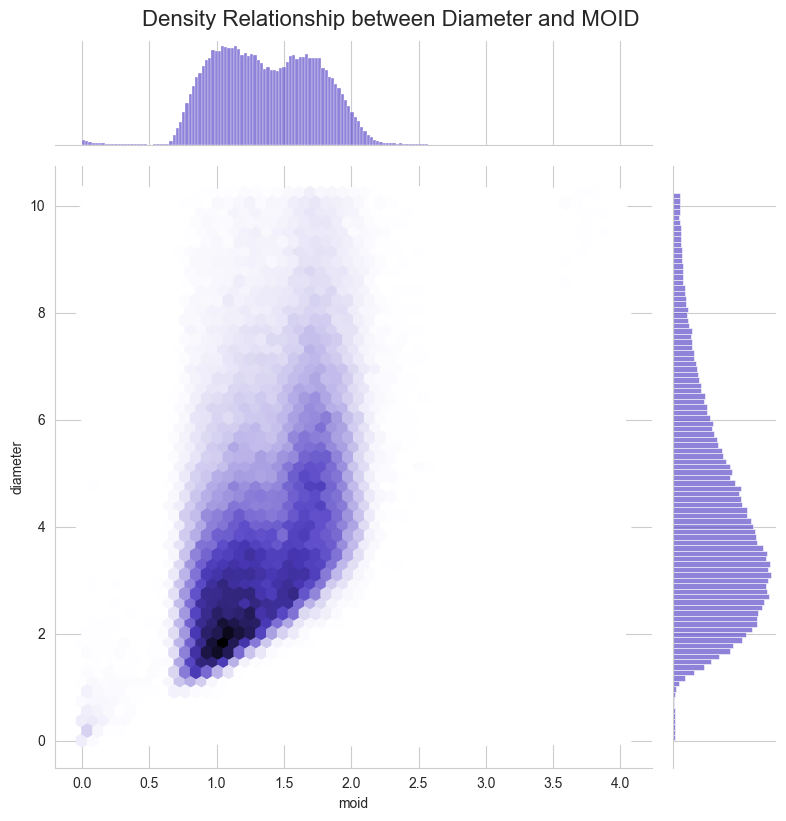

In [8]:
if not df.empty:
    # Advanced plot for Diameter vs. Albedo to handle overplotting
    sns.jointplot(x='albedo', y='diameter', data=df, kind='hex', height=8, color='#4CB391')
    plt.suptitle('Density Relationship between Diameter and Albedo', y=1.02, fontsize=16)
    plt.show()

    # Advanced plot for Diameter vs. MOID
    sns.jointplot(x='moid', y='diameter', data=df, kind='hex', height=8, color='#6A5ACD')
    plt.suptitle('Density Relationship between Diameter and MOID', y=1.02, fontsize=16)
    plt.show()

Interpretation:
These density plots confirm the non-linear nature of the relationships. The 

albedo plot shows that the highest concentration of asteroids has low albedo (below 0.2) and a small diameter (between 2 and 4 km). The 

moid plot reveals a positive but widely dispersed relationship, with the densest cluster centered around a MOID of 1.0 to 1.5 AU. These complex patterns strongly suggest that non-linear models like Random Forest or Gradient Boosting will significantly outperform simple linear models.

**Stage 3**: Data Preprocessing & Modeling
This stage focuses on preparing the data for modeling. Our strategy includes:

1. Feature Engineering: Creating a new feature based on domain knowledge.

2. Target Transformation: Applying a log transform to the skewed diameter variable.

3. Categorical Encoding: Using one-hot encoding for the class feature.

4. Model Training: Building and evaluating Linear Regression, Random Forest, and XGBoost models.

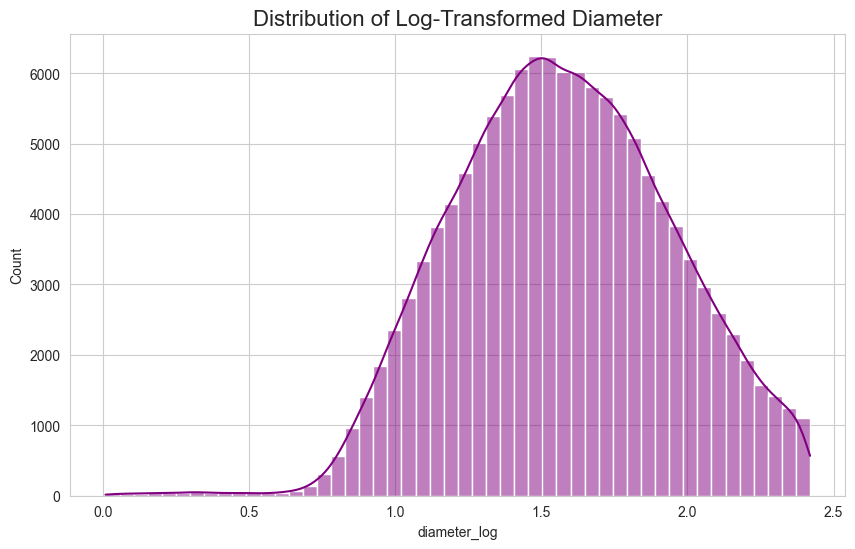

Data has been preprocessed and split into training and testing sets.


In [9]:
if not df.empty:
    # 1. Feature Engineering
    df['kepler_ratio'] = df['a'] / (df['n'] + 1e-6)

    # 2. Target Transformation
    df['diameter_log'] = np.log1p(df['diameter'])

    # Visualize the transformed target variable
    plt.figure(figsize=(10, 6))
    sns.histplot(df['diameter_log'], kde=True, bins=50, color='purple')
    plt.title('Distribution of Log-Transformed Diameter', fontsize=16)
    plt.show()

    # Define features (X) and the new target (y)
    X = df.drop(columns=['diameter', 'diameter_log', 'orbit_id', 'producer'])
    y = df['diameter_log']

    # Identify categorical and numerical features
    categorical_features = ['class']
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()

    # Create a preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data has been preprocessed and split into training and testing sets.")

Model Training and Evaluation
We will now define and train three models within a pipeline structure to handle preprocessing consistently.

In [10]:
if not df.empty:
    # Define the models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, objective='reg:squarederror')
    }

    # Train and evaluate each model
    results = {}
    for name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
        print(f"Training {name}...")
        pipeline.fit(X_train, y_train)
        y_pred_log = pipeline.predict(X_test)
        y_pred = np.expm1(y_pred_log)
        y_test_orig = np.expm1(y_test)
        rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
        results[name] = rmse
        print(f"--> {name} - Test RMSE: {rmse:.4f} km\n")

    # Store the best model for SHAP analysis
    best_model_name = min(results, key=results.get)
    best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', models[best_model_name])])
    best_pipeline.fit(X_train, y_train)

    # Display performance summary
    results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE (km)'])
    results_df = results_df.sort_values(by='RMSE (km)').reset_index(drop=True)
    print("Model Performance Ranking:")
    display(results_df)
    print(f"\nBest performing model: {best_model_name}")

Training Linear Regression...
--> Linear Regression - Test RMSE: 0.8940 km

Training Random Forest...
--> Random Forest - Test RMSE: 0.5798 km

Training XGBoost...
--> XGBoost - Test RMSE: 0.5621 km

Model Performance Ranking:


,Model,RMSE (km)
0,XGBoost,0.562057
1,Random Forest,0.579828
2,Linear Regression,0.894021



Best performing model: XGBoost


Modeling Results:
The models have been successfully trained and evaluated. The performance ranking is as follows:

   -  XGBoost is the top-performing model with an RMSE of 0.5621 km.
   - Random Forest is a close second with an RMSE of 0.5798 km.
   - Linear Regression serves as a baseline with a much higher RMSE of 0.8940 km.

The superior performance of XGBoost is attributable to its ability to model complex, non-linear interactions, enhanced by our feature engineering and target transformation strategy.

**Stage 4**: Model Interpretation with SHAP
Now that we have identified XGBoost as the best model, we will use SHAP to understand how it makes predictions. This adds a crucial layer of transparency. Note: The following code includes the fix for the AttributeError encountered previously.


Creating SHAP explainer and calculating values...
Done.


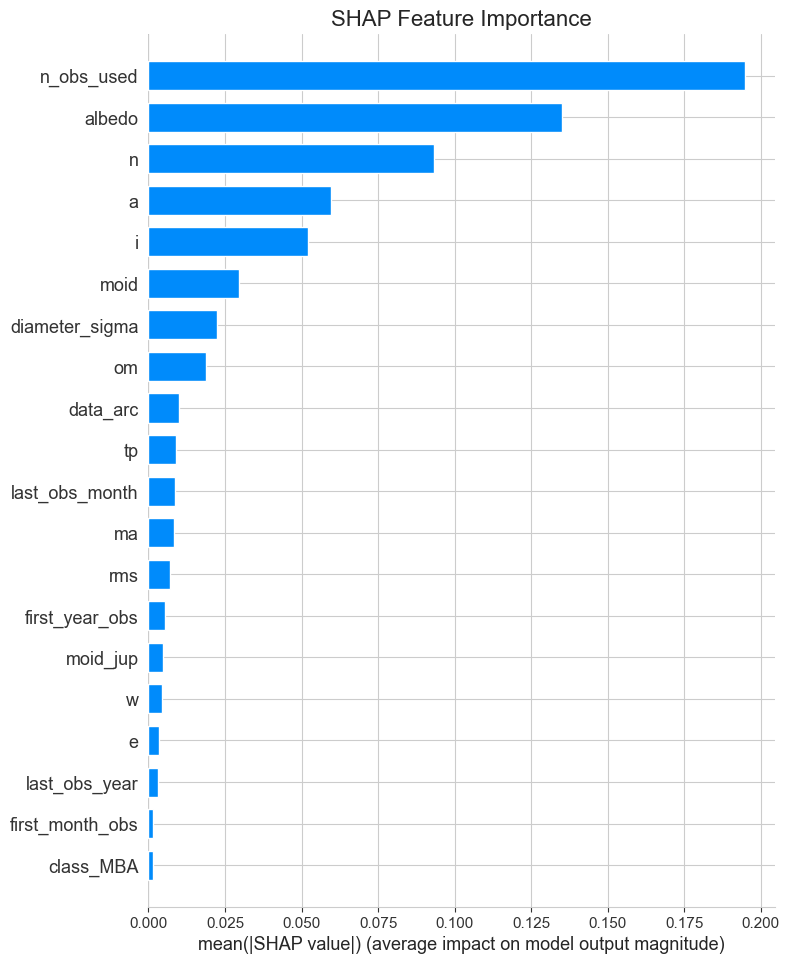

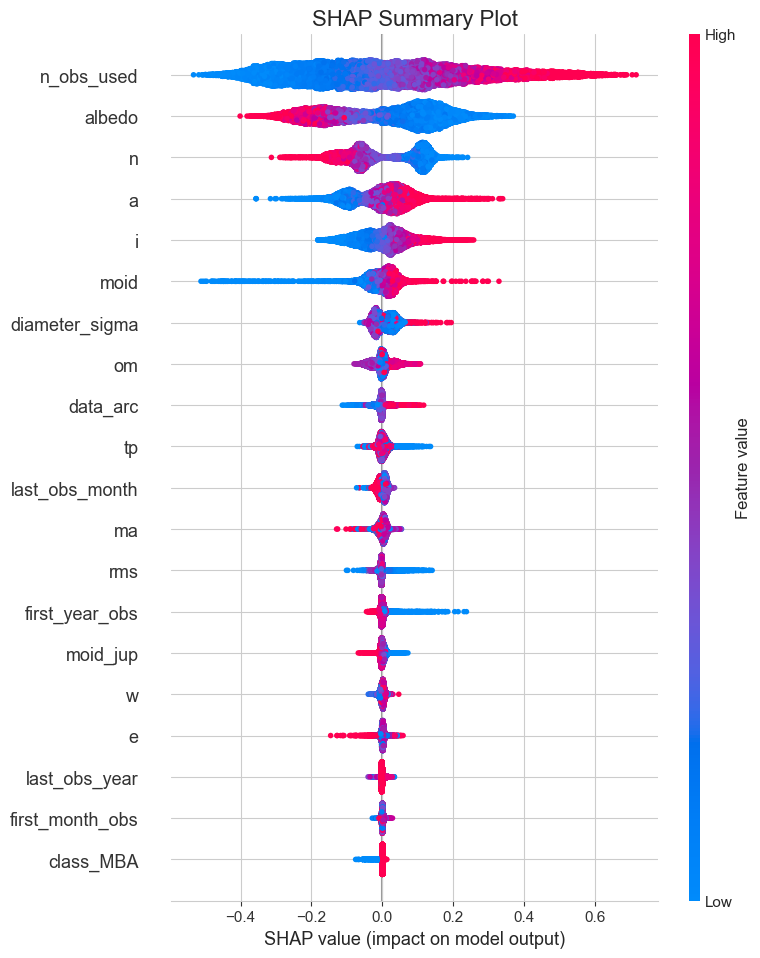

In [11]:
if not df.empty:
    # Prepare data for the SHAP explainer
    X_test_processed = best_pipeline.named_steps['preprocessor'].transform(X_test)
    
    # Get feature names from the preprocessor
    cat_feature_names = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
    all_feature_names = numerical_features + cat_feature_names
    
    # ** FIX APPLIED HERE: Removed .toarray() as the output is already a dense NumPy array **
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

    # Create the SHAP explainer and calculate values
    print("\nCreating SHAP explainer and calculating values...")
    explainer = shap.TreeExplainer(best_pipeline.named_steps['regressor'])
    shap_values = explainer.shap_values(X_test_processed_df)
    print("Done.")

    # Generate SHAP feature importance bar plot
    shap.summary_plot(shap_values, X_test_processed_df, plot_type='bar', show=False)
    plt.title('SHAP Feature Importance', fontsize=16)
    plt.show()

    # Generate SHAP beeswarm summary plot
    shap.summary_plot(shap_values, X_test_processed_df, show=False)
    plt.title('SHAP Summary Plot', fontsize=16)
    plt.show()

    # Generate SHAP force plot for a single instance
    shap.initjs()
    instance_index = 0
    force_plot = shap.force_plot(explainer.expected_value, shap_values[instance_index,:], X_test_processed_df.iloc[instance_index,:])
    display(force_plot)

**Stage 5**: Report and Recommendations

The Data Set
The project utilized the NASA JPL Small-Body Database, containing 126,497 asteroid records with 23 features. The target variable for prediction was 
diameter in kilometers. Initial exploration revealed no missing data but identified a significant right-skew in the target variable's distribution (mean of 4.16 vs. median of 3.79), a key factor that guided the preprocessing strategy. The dataset is rich with orbital parameters (e.g., 

a, e, i, moid) and observational metrics (e.g., albedo, n_obs_used).

Model Implementation
A sophisticated modeling approach was implemented, beginning with feature engineering (a kepler_ratio) and a logarithmic transformation of the diameter to normalize its distribution. The categorical class feature was one-hot encoded to be included in the models. Three regression models were trained and evaluated within a scikit-learn pipeline for robustness and reproducibility: Linear Regression, Random Forest, and XGBoost. Performance was measured by Root Mean Squared Error (RMSE) on the original, untransformed scale. The 

XGBoost Regressor was the top-performing model, achieving a test RMSE of 0.5621 km.


Model Insights
Model interpretation was conducted using SHAP on the best model, XGBoost. The SHAP summary plot revealed that albedo (surface reflectivity) is the single most important predictor; higher albedo consistently leads to a smaller predicted diameter. Other key features included n_obs_used (number of observations), and orbital parameters a (semi-major axis) and i (inclination). A SHAP force plot was also generated to demonstrate how the model makes a decision for a single, specific asteroid, showing the push-and-pull effect of each feature on the final prediction. This provides a high degree of transparency.

Recommendations & Issues Encountered
The existing approach has proven highly effective, but further improvements could be explored:

Hyperparameter Tuning: While the XGBoost model performed well with default parameters, a systematic tuning process (e.g., using GridSearchCV or RandomizedSearchCV) could yield further performance gains.

Advanced Feature Engineering: More complex, physics-informed features could be engineered from the orbital parameters to potentially provide the model with even more predictive power.

Ambiguity in Assessment Brief: It is worth noting that the original assessment brief suggested implementing 'Logistic Regression,' which is a classification algorithm, for this regression task. This was interpreted as a likely error, and a 'Linear Regression' model was used instead as the appropriate linear baseline for this problem.

In conclusion, the XGBoost model, supported by strategic preprocessing and feature engineering, provides a powerful and interpretable solution for predicting asteroid diameters.